In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_folder = os.path.dirname(os.path.abspath("./"))
sys.path.append(parent_folder)

import numpy as np

In [2]:
from sklearn.datasets import make_moons
from data._utils import add_noise

def make_moons_random_assignment(n_samples, noise=0, seed=0):
    np.random.seed(seed)
    X, l = make_moons(n_samples=n_samples, random_state=seed, noise=noise)
    # X, l = add_noise(X, l, 20, 0.1)
    class0 = np.where(l == 0)[0]
    class1 = np.where(l == 1)[0]
    # choice_class0 = np.random.choice(len(class0), replace=False, size=n_samples // 100 * n_swap)
    # choice_class1 = np.random.choice(len(class1), replace=False, size=n_samples // 100 * n_swap)
    # l[class0[choice_class0]] = 1
    # l[class1[choice_class1]] = 0
    return X, l

### twoMoonsDatasets[noise][run]
np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
twoMoonsDatasets = [
    [make_moons_random_assignment(500, noise=noise, seed=seed) for seed in random_seeds]
    for noise in np.arange(0, 0.21, 0.01)
]

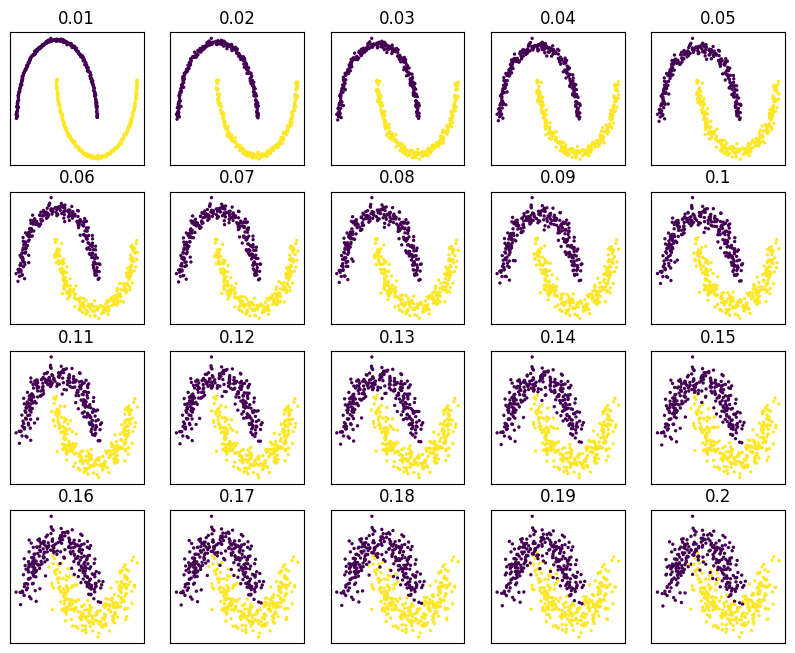

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(2*5, 2*5))
G = gridspec.GridSpec(5, 5)

for noise in range(0,20):
    ax = plt.subplot(G[noise // 5, noise % 5])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{np.arange(0, 0.21, 0.01)[noise + 1]}")
    X, l = twoMoonsDatasets[noise+1][0]
    plt.scatter(X[:, 0], X[:, 1], s=2, c=l)

plt.savefig("imgs/TwoMoons_noise_data.png")

In [4]:
import cache_magic

import time
from collections import defaultdict
from data._metrics import METRICS
from data._utils import insert_dict

def calc():
    eval_results = defaultdict(list)

    for noise in range(len(twoMoonsDatasets)):
        for run in range(len(twoMoonsDatasets[0])):
            X, l = twoMoonsDatasets[noise][run]
            for name, metric_fn in METRICS.items():
                start_time = time.time()
                start_process_time = time.process_time()
                value = metric_fn(X, l)
                end_process_time = time.process_time()
                end_time = time.time()
                insert_dict(eval_results, {
                    "measure": name, 
                    "noise": noise, 
                    "run": run,
                    "value": value,
                    "time": end_time - start_time,
                    "process_time": end_process_time - start_process_time,
                })
    return eval_results

%cache eval_results_noise = calc()

%cache magic is now registered in ipython
loading cached value for variable 'eval_results_noise'. Time since pickling  0:03:24.642597


In [5]:
import pandas as pd

SELECTED_MEASURES = [
    "DISCO",
    # "DC_DUNN",
    ### Competitors
    "DBCV",
    "DCSI",
    # "S_DBW",
    "CDBW",
    "CVDD",
    # "CVNN",
    "DSI",
    ### Gauss
    "SILHOUETTE",
    "DUNN",
    # "DB",
    # "CH",
]

df = pd.DataFrame(data=eval_results_noise)
df = df[df.measure.isin(SELECTED_MEASURES)]
df["measure"] = pd.Categorical(df["measure"], SELECTED_MEASURES)
df = df.sort_values("measure")
# df.groupby("measure").sum()

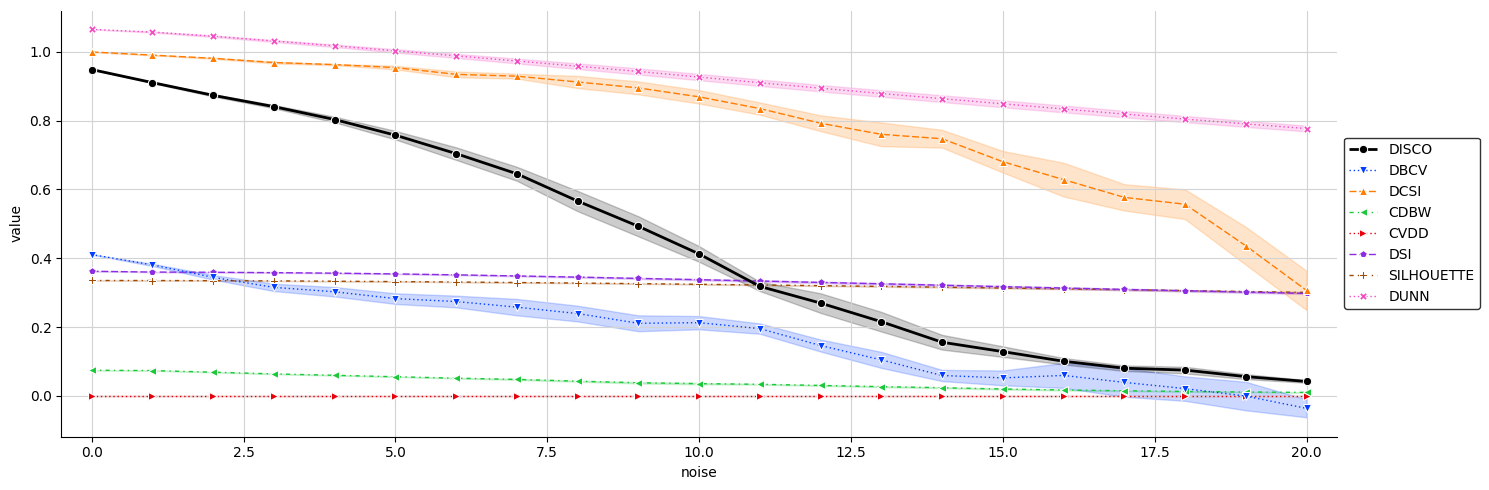

In [6]:
from data._utils import plot_lineplot

plot_lineplot(df, "noise", "value", "measure", x_range=(-0.5, 20.5), y_range=(None, None), errorbar="se")
plt.savefig("imgs/TwoMoons_noise.png")

In [7]:
import cache_magic

from data._metrics import DISCO

def calc():
    min_points_results = defaultdict(list)

    for noise in range(len(twoMoonsDatasets)):
        for run in range(len(twoMoonsDatasets[0])):
            X, l = twoMoonsDatasets[noise][run]
            for min_points in range(1, 31, 2):
                start_time = time.time()
                start_process_time = time.process_time()
                value = DISCO(X, l, min_points=min_points)
                end_process_time = time.process_time()
                end_time = time.time()
                insert_dict(
                    min_points_results,
                    {
                        "min_points": min_points,
                        "noise": noise,
                        "run": run,
                        "value": value,
                        "time": end_time - start_time,
                        "process_time": end_process_time - start_process_time,
                    },
                )
    return min_points_results

%cache min_points_results = calc()

loading cached value for variable 'min_points_results'. Time since pickling  0:00:22.105153


In [8]:
df = pd.DataFrame(data=min_points_results)
df = df.sort_values("min_points")
df.groupby("min_points").sum()

,noise,run,value,time,process_time
min_points,,,,,
1,2100,945,99.011080,10.111366,312.382216
3,2100,945,97.029616,11.151660,342.779758
5,2100,945,93.994942,11.657809,354.889253
7,2100,945,88.890385,11.822743,364.423912
9,2100,945,84.350450,11.538808,361.033719
11,2100,945,80.274635,11.396968,358.526480
13,2100,945,76.479996,11.696756,367.311389
15,2100,945,72.471801,12.045988,378.211090
17,2100,945,68.772870,12.009680,377.231637


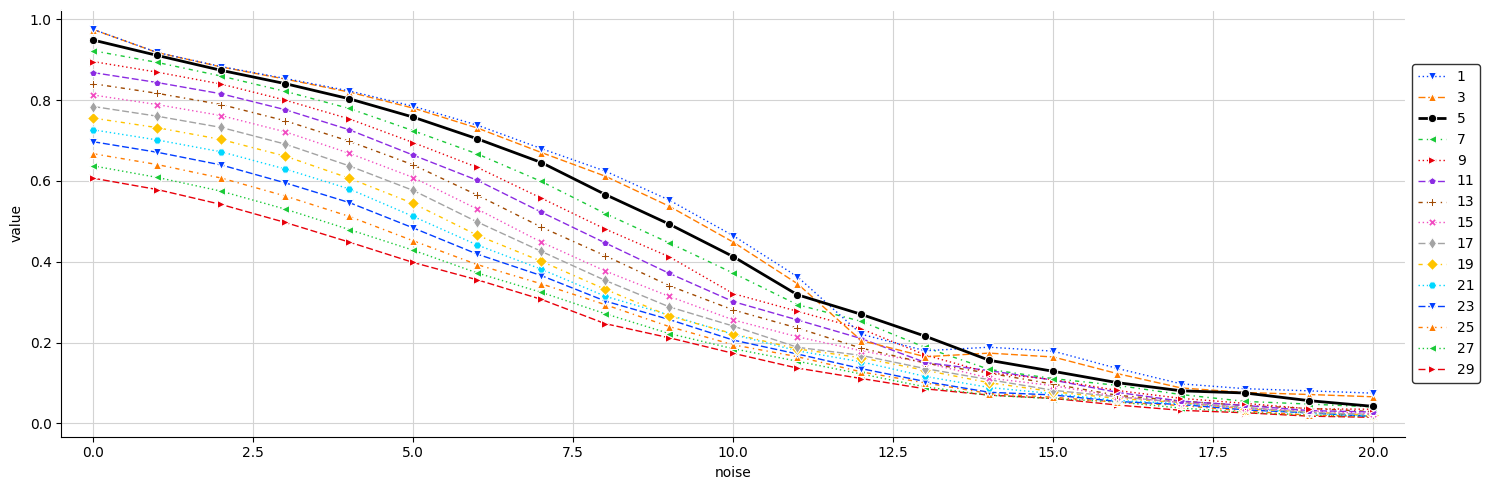

In [9]:
import pandas as pd
from data._utils import plot_lineplot

df = pd.DataFrame(data=min_points_results)
plot_lineplot(df, "noise", "value", "min_points", x_range=(-0.5, 20.5), y_range=(None, None), errorbar=None, highlight=3)
plt.savefig("imgs/TwoMoons_noise_DISCO_min_points.png")